## simulation study

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from Brownian_test_func import *

info = pd.read_csv("data/info.csv")
Count = pd.read_csv("data/st_count.csv", index_col = 0)
Count = Count.loc[:,info.iloc[:,0]]
symbol_all = Count.index

loc = pd.DataFrame({'x':info['x'],
                    'y':info['y']})

adata_data = sc.AnnData(Count.T)
adata_data.var_names = Count.index
adata_data.obs_names = Count.columns
adata_data.obs['celltype'] = info['Region'].values
symbol = adata_data.var_names

sc.pp.filter_genes(adata_data, min_cells=20)
sc.pp.normalize_total(adata_data, inplace=True)
sc.pp.log1p(adata_data)

symbol_sel = adata_data.var_names

In [2]:
labels = adata_data.obs['celltype'].values

# generate simulate data

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform

#np.random.seed(42)

# 生成样本位置数据
#num_samples = 1000
#locations = np.random.rand(num_samples, 2)  # 生成随机的2D坐标
num_samples = loc.shape[0]
locations = loc.values
scale = 1

# 根据位置计算欧氏距离的协方差矩阵
def get_distance_cov(locations, scale=1.0):
    dists = squareform(pdist(locations, 'euclidean'))
    cov = np.exp(-dists**2 / (2.0 * scale**2))
    return cov

# 根据 location得到distance based的
base_cov = get_distance_cov(locations, scale)

# 根据标签生成协方差矩阵
def get_label_cov(labels, base_cov, base_mean, label, scale=1.0):
    label_mask = (labels == label).astype(float)
    label_cov = np.outer(label_mask, label_mask) * base_cov
    label_mean = mean * label_mask
    return label_cov,label_mean

# 生成随机的协方差矩阵
def generate_random_cov_matrix(size):
    A = np.random.rand(size, size)
    cov_matrix = np.dot(A, A.T)  # 生成正定矩阵
    # 标准化到 [0, 1] 范围
    cov_matrix = (cov_matrix - cov_matrix.min()) / (cov_matrix.max() - cov_matrix.min())
    np.fill_diagonal(cov_matrix, 1)
    return cov_matrix


# 生成基因表达数据
num_genes = 3000 ##adata_data.shape[1]
svg_proportion = 0.5
num_svg = int(num_genes * svg_proportion)
num_non_svg = num_genes - num_svg

# 记录每个基因的scale值
scale_list = np.zeros(num_genes)  # 初始化scale列表
label_list = ['NO'] * num_genes

# 生成非SVG基因表达数据，使用均值为0，标准差为1的正态分布
non_svg_expression = np.random.normal(loc=1, scale=1, size=(num_samples, num_non_svg))
non_svg_expression = np.clip(non_svg_expression, 0, None)  # 将表达值小于0的部分截断为0

# 生成SVG基因表达数据
svg_expression = []
for i in range(num_svg):
    mean = np.random.uniform(2, 3, size=num_samples)  # SVG基因的表达中心在[2, 5]之间
    
    scale = np.random.uniform(0.1, 0.8)  # 生成随机系数
    
    scale_list[num_non_svg + i] = scale
    
    #label = np.random.choice(np.unique(labels))  # 随机选择一个标签
    label = 'Cancer'
    label_list[num_non_svg + i] = label
    
    label_cov, label_mean = get_label_cov(labels, base_cov, mean, label, scale=scale)  # 生成标签相关的协方差矩阵
    label_mean = label_mean +  np.random.uniform(0,2, size=num_samples)
    final_cov = label_cov
    
    expression_rand = np.random.uniform(1,5, size=num_samples)
    expression_rand = np.clip(expression_rand, 0, 100)
    
    # 对于cancer区域设置为0，其余为非0
    #expression_rand = expression_rand * ((labels != label).astype(float))
    
    # 随机生成final_cov
    random_cov = generate_random_cov_matrix(num_samples)
    final_cov = random_cov
    
    # 将cov设成location的
    #final_cov = base_cov
    
    expression_st = np.random.multivariate_normal(label_mean, final_cov, size=1).flatten() 
    #expression_st = expression_st/np.max(expression_st)*5
    
    expression = scale * expression_st + (1-scale)*expression_rand
    
    expression = np.clip(expression, 0, 20)  # 将表达值截断在0到20之间
    svg_expression.append(expression)
svg_expression = np.array(svg_expression).T

# 合并SVG和非SVG基因表达数据
gene_expression = np.hstack((non_svg_expression, svg_expression))

# 创建数据框以便进一步分析
gene_names = [f'Gene_{i}' for i in range(num_genes)]
expression_df = pd.DataFrame(gene_expression, columns=gene_names)


/tmp/ipykernel_31953/1014658930.py:86: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  expression_st = np.random.multivariate_normal(label_mean, final_cov, size=1).flatten()


In [85]:
#location_df = pd.DataFrame(loc, columns=['x', 'y'])

# 保存数据以便进一步使用
expression_df.to_csv('sim_spatial_count.csv')
#location_df.to_csv('sim_location.csv')

scale_list = pd.DataFrame(scale_list, columns=['scale'])
scale_list.index = expression_df.columns.values
scale_list.to_csv('scale_list.csv', index=False)

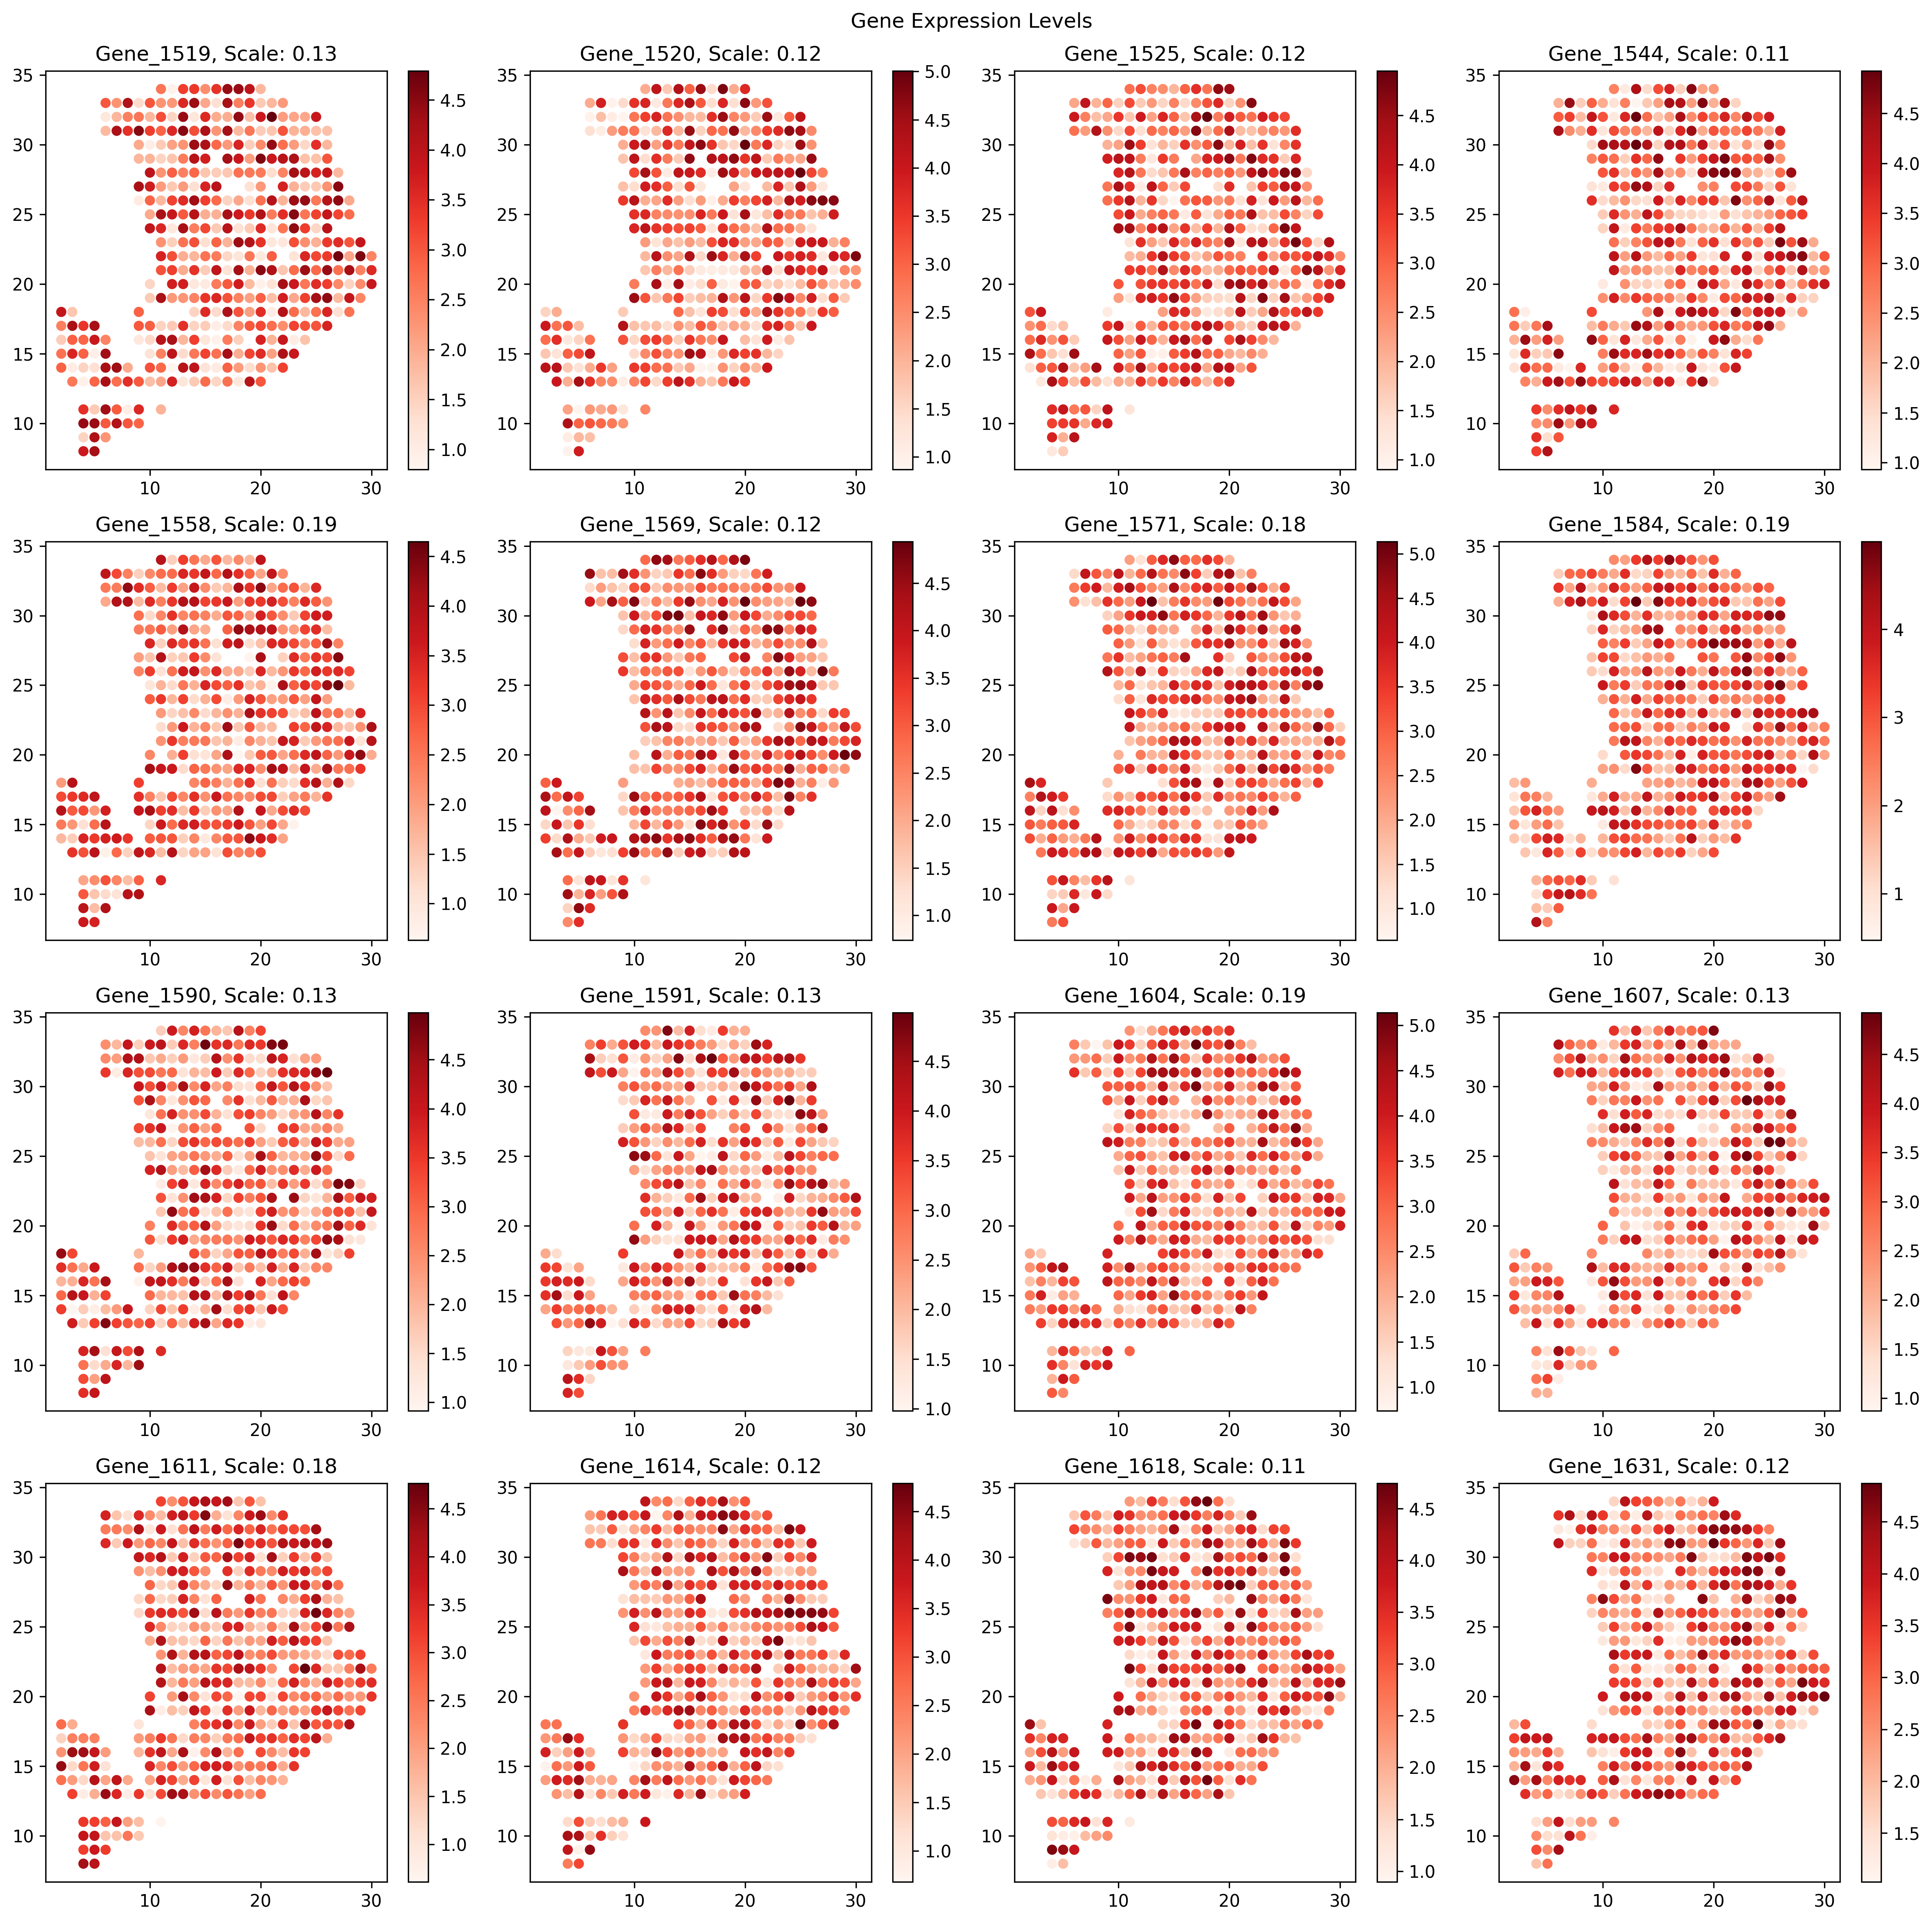

In [247]:
# 设置绘图的大小和子图布局
fig, axes = plt.subplots(4, 4, figsize=(16, 16),dpi = 300)
fig.suptitle('Gene Expression Levels')

# 选择要绘制的基因
#genes_to_plot = [f'Gene_{i}' for i in range(2000, 2020)]
genes_to_plot = genes_2.index[0:20]
# 遍历每个子图位置和基因
for ax, gene_name in zip(axes.flatten(), genes_to_plot):
    values_to_color = expression_df[gene_name].values
    
    # 创建散点图
    scatter = ax.scatter(loc['x'].values, loc['y'].values, c=values_to_color, cmap='Reds', s=25)
    
    # 添加颜色条
    fig.colorbar(scatter, ax=ax, orientation='vertical')
    ax.set_title(f'{gene_name}, Scale: {scale_list.loc[gene_name, "scale"]:.2f}')

# 调整子图布局
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# 显示图像
plt.show()

## Setting the pathways

In [89]:
# read the scale_list
scale_list = pd.read_csv('scale_list.csv')
expression = pd.read_csv('sim_spatial_count.csv')
expression = expression.iloc[:,1:]
scale_list.index = expression.columns.values

# # 设置绘图的大小
# plt.figure(figsize=(4, 4))
# gene_name = 'Gene_6959'
# values_to_color = expression_df[gene_name].values
# plt.scatter(loc['x'].values, loc['y'].values, c=values_to_color, cmap='Reds', s=25)
# plt.colorbar()
# plt.title(scale_list.loc[gene_name].values)
# plt.show()

In [261]:
# 根据scale进行选择：选择不同范围的基因
genes_0 = scale_list[scale_list['scale'] == 0]
genes_1 = scale_list[(scale_list['scale'] >= 0.1) & (scale_list['scale'] <= 0.15)]
genes_2 = scale_list[(scale_list['scale'] >= 0.1) & (scale_list['scale'] <= 0.2)]
genes_3 = scale_list[(scale_list['scale'] >= 0.1) & (scale_list['scale'] <= 0.25)]
genes_4 = scale_list[(scale_list['scale'] >= 0.1) & (scale_list['scale'] <= 0.3)]
genes_5 = scale_list[(scale_list['scale'] >= 0.3) & (scale_list['scale'] <= 0.4)]

# 随机选择基因构建 pathways
np.random.seed(42)  # 为了结果可重复，设置随机种子
pathways_1 = [genes_0.sample(n=50, random_state=i).index.tolist() + genes_1.sample(n=50, random_state=i+10).index.tolist() for i in range(10)]
pathways_2 = [genes_0.sample(n=50, random_state=i+20).index.tolist() + genes_2.sample(n=50, random_state=i+30).index.tolist() for i in range(10)]
pathways_3 = [genes_0.sample(n=50, random_state=i+20).index.tolist() + genes_3.sample(n=50, random_state=i+30).index.tolist() for i in range(10)]
pathways_4 = [genes_0.sample(n=50, random_state=i+20).index.tolist() + genes_4.sample(n=50, random_state=i+30).index.tolist() for i in range(10)]
pathways_5 = [genes_0.sample(n=50, random_state=i+20).index.tolist() + genes_5.sample(n=50, random_state=i+30).index.tolist() for i in range(10)]

# 合并所有 pathway
all_pathways = pathways_1 + pathways_2 + pathways_3 + pathways_4 + pathways_5

# 将每个 pathway 转换为 DataFrame 并保存为 CSV 文件
pathway_df_list = []
for i, pathway in enumerate(all_pathways):
    pathway_df = pd.DataFrame({
        'pathway': [f'Pathway_{i+1}'] * len(pathway),
        'gene': pathway
    })
    pathway_df_list.append(pathway_df)

final_pathway_df = pd.concat(pathway_df_list, ignore_index=True)

# 保存为 CSV 文件
final_pathway_df.to_csv('pathways.csv', index=False)

## Run our method

In [262]:
output_csv = 'sim_ours_res.csv'

pd.DataFrame(columns=['name', 'n_gene', 'pval', 'dcov', 'dcor']).to_csv(output_csv, index=False)

GO_id = []
GO_name = []
pval = []
est = []
n_gene = []

for i in trange(1,len(all_pathways)+1):
    #if i%100==0:
    #    print(f'-----Round------{i}')

    this_pathway = 'Pathway_'+str(i)

    gene_str = final_pathway_df[final_pathway_df['pathway'] == this_pathway]['gene'].tolist()

    gene_number = len(gene_str)

    # Assuming gene_str is defined and adata_data is your AnnData object
    data =expression[gene_str].values

    rpy2.robjects.numpy2ri.activate()

    ro.r.assign("data", data)
    ro.r.assign("loc", loc.values)
    ro.r.assign("n_perm", 100)

    rpy2.robjects.numpy2ri.activate()
    robjects.r(
               '''
                library(energy)
                x <- data
                y <- loc

                set.seed(1)
                res <- dcov.test(x, y, R=n_perm)

                pval <- res$p.value
                dcov <- res$estimates[1]
                dcor <- res$estimates[2]
               '''
               )
    #symbol = robjects.r['symbol']
    p_val = robjects.r['pval'][0]
    dcov = robjects.r['dcov'][0]
    dcor = robjects.r['dcor'][0]

    # Construct a DataFrame for the current iteration
    current_res = pd.DataFrame({'name': [this_pathway],
                                'n_gene': [gene_number],
                                'pval': [p_val],
                                'dcov': [dcov],
                                'dcor': [dcor]})
        # Append the result of the current iteration to the CSV file
    current_res.to_csv(output_csv, mode='a', header=False, index=False)

100%|█████████████████████████| 50/50 [00:01<00:00, 37.07it/s]
